# Introduction
In this competition, we’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. We have access to a dataset of 10,000 tweets that were hand classified.

I wanted to try to use LSTM in NLP as a part of my learning journey. I tried to explain some concept that were important also for me to understand. My inspiration was this notebook: https://www.kaggle.com/code/tmishinev/nlp-disaster-tweets-keras-lstm


I hope that you'll enjoy this notebook!


## LSTM
Long Short-Term Memory (LSTM) networks have emerged as powerful tools in the field of Natural Language Processing (NLP), offering a solution to the challenges posed by the sequential and variable-length nature of language data. LSTMs are a type of recurrent neural network (RNN) that has been specifically designed to address the vanishing gradient problem, which often hinders the training of traditional RNNs.

LSTM works particularly well in this area as it remembers patterns and important information well. In LSTM, determining the class uses a multiple word string. Correct Embedding will enable the LSTM model to guess the correct meaning of the text and classify it.

# Content:
1. [Imports](#1)
2. [Tokenizer:](#2)
    * [fit_on_texts](#2.1)
    * [texts_to_sequences](#2.2)
    * [pad_sequences](#2.1)
3. [Split of data into training and testing](#3)
4. [LSTM Model:](#4)
    * [Embedding](#4.1)
    * [Summary](#4.2)
5. [Evaluation:](#5)
    * [Confusion Matrix](#5.1)
    * [Accuracy](#5.2)
    * [Precision](#5.3)
    * [Recall](#5.4)
    * [F1 Score](#5.5)
6. [Predictions](#6)

# <a id="1">Imports</a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

2024-06-11 10:36:29.563976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# <a id="2">Tokenizer</a>

This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, tf-idf etc.

By default, all punctuation is removed, turning the texts into space-separated sequences of words (words may include the ' character). These sequences are then split into lists of tokens. They will then be indexed or vectorized.

Documentation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

Data preparation is performed by Tokenizer to convert input data to integer encoded.

In [6]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')

### <a id="2.1">fit_on_texts</a>

* Updates internal vocabulary based on a list of texts
* In the case where texts contains lists, we assume each entry of the lists to be a token
* Required before using texts_to_sequences or texts_to_matrix

In [9]:
tokenizer.fit_on_texts(train['text'].values)

### <a id="2.2">texts_to_sequences</a>

* Transforms each text in texts to a sequence of integers.
* Only top num_words-1 most frequent words will be taken into account
* Only words known by the tokenizer will be taken into account

In [12]:
X = tokenizer.texts_to_sequences(train['text'].values)

### <a id="2.3">pad_sequences</a>

This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.

* Sequences that are shorter than num_timesteps are padded with value until they are num_timesteps long
* Sequences longer than num_timesteps are truncated so that they fit the desired length

In [15]:
X = pad_sequences(X)

# <a id="3">Split of data into training and testing</a>

In [18]:
y = train['target']

X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size = 0.2, random_state =41)

# <a id="4">LSTM Model</a>

## <a id="4.1">Embedding layer</a>

Turns positive integers (indexes) into dense vectors of fixed size.

<b>e.g. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]</b>

This layer can only be used on positive integer inputs of a fixed range.

<b>Input shape:</b>
2D tensor with shape: (batch_size, input_length).

<b>Output shape:</b>
3D tensor with shape: (batch_size, input_length, output_dim).

<b>Arguments:</b>
* input_dim: Size of the vocabulary, i.e. maximum integer index + 1.
* output_dim: Dimension of the dense embedding.
* embeddings_initializer: Initializer for the embeddings matrix
* embeddings_regularizer: Regularizer function applied to the embeddings matrix
* embeddings_constraint: Constraint function applied to the embeddings matrix
* mask_zero: Whether or not the input value 0 is a special "padding" value that should be masked out

Documentation: https://keras.io/api/layers/core_layers/embedding/



### Description

This layer is most often used in NLP tasks. It transforms string into numerical values to fit the model. It precisely converts a word into a fixed length vector of defined size. The fixed length of word vectors helps us to represent words in a better way along with reduced dimensions. The position of the vectors is defined by the words surrounding the word, they should be closer to that vector in space.

The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.

You can check the visualization of these vectors here: https://projector.tensorflow.org/

### Visualization of word embeddings
![image.png](https://miro.medium.com/v2/resize:fit:990/1*Fat62b1ZITOFMPXTcHNkLw.jpeg)

In [21]:
model = Sequential([
    Embedding(max_features, 32, input_length = X.shape[1]),
    Dropout(0.2),
    Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.4)),
    Dense(1,activation='sigmoid'),
])

model.compile(loss = 'binary_crossentropy', optimizer='adam' ,metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_valid, y_valid))
y_pred = model.predict(X_valid).round()

2024-06-11 10:19:06.690052: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/3
191/191 [==============================] - 25s 108ms/step - loss: 0.5795 - accuracy: 0.6821 - val_loss: 0.4461 - val_accuracy: 0.7984
Epoch 2/3
191/191 [==============================] - 25s 133ms/step - loss: 0.3984 - accuracy: 0.8292 - val_loss: 0.4214 - val_accuracy: 0.8030
Epoch 3/3
48/48 [==============================] - 2s 23ms/step


In [23]:
print("Shape of predictions:", y_pred.shape)

Shape of predictions: (1523, 1)


## <a id="4.2">Summary</a>

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 32)            96000     
                                                                 
 dropout (Dropout)           (None, 31, 32)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 112,705
Trainable params: 112,705
Non-trainable params: 0
_________________________________________________________________


# <a id="5">Evaluation</a>

## <a id="5.1">Confusion Matrix</a>

Text(70.72222222222221, 0.5, 'Real Labels')

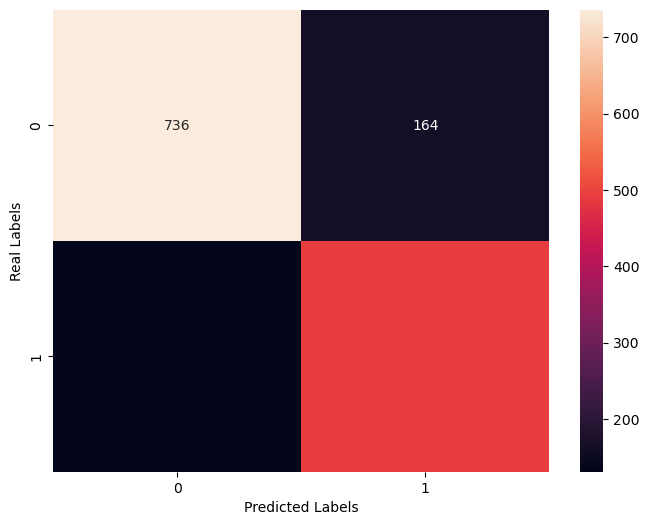

In [29]:
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_pred, y_valid), annot=True, fmt='', cmap='rocket')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

## <a id="5.2">Accuracy</a>

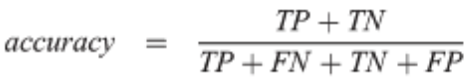

In [32]:
accuracy_score(y_pred, y_valid)

0.8063033486539725

<Axes: title={'center': 'Accuracy'}>

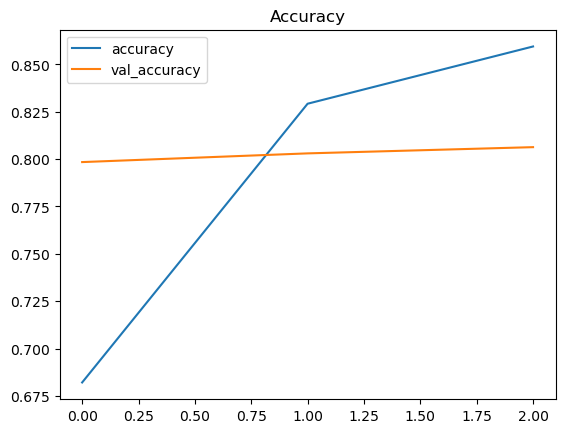

In [34]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

## <a id="5.3">Precision</a>

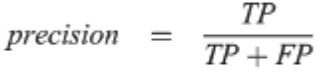

In [37]:
precision_score(y_pred, y_valid)

0.75

## <a id="5.4">Recall</a>

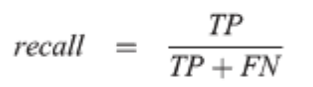

In [40]:
recall_score(y_pred, y_valid)

0.7897271268057785

## <a id="5.5">F1 Score</a>

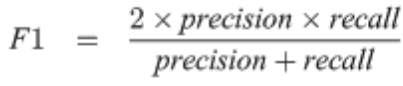

In [43]:
f1_score(y_pred, y_valid)

0.7693510555121188

# <a id="6">Predictions</a>

We will create a new model and fit it with all train data. However, before doing so again, we need to use Tokenizer.

In [46]:
l =50
max_features=5000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train['text'].values)
X = tokenizer.texts_to_sequences(train['text'].values)
X = pad_sequences(X, maxlen =l)

tokenizer.fit_on_texts(train['text'].values)
X_test = tokenizer.texts_to_sequences(test['text'].values)
X_test = pad_sequences(X_test, maxlen =l)

In [48]:
model = Sequential([
    Embedding(max_features, 32, input_length = X.shape[1]),
    Dropout(0.2),
    Bidirectional(LSTM(100, dropout=0.2, return_sequences=True,recurrent_dropout=0.4)),
    Dropout(0.2),
    Bidirectional(LSTM(100, dropout=0.2, return_sequences=False,recurrent_dropout=0.4)),
    Dropout(0.2),
    Dense(1,activation='sigmoid'),
])

adam = optimizers.Adam(learning_rate=2e-3)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])

In [50]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
)

model.fit(X, y, epochs = 10,validation_split = 0.2 ,callbacks=[early_stopping], batch_size=64)

Epoch 1/10
96/96 [==============================] - 98s 949ms/step - loss: 0.5572 - accuracy: 0.7144 - val_loss: 0.4751 - val_accuracy: 0.7702
Epoch 2/10
96/96 [==============================] - 96s 1s/step - loss: 0.3733 - accuracy: 0.8470 - val_loss: 0.4425 - val_accuracy: 0.8070
Epoch 3/10
96/96 [==============================] - 112s 1s/step - loss: 0.2907 - accuracy: 0.8865 - val_loss: 0.4964 - val_accuracy: 0.7833
Epoch 4/10
96/96 [==============================] - 109s 1s/step - loss: 0.2523 - accuracy: 0.9069 - val_loss: 0.5180 - val_accuracy: 0.7715


In [51]:
predictions = model.predict(X_test).round()
print("Shape of predictions:", predictions.shape)

102/102 [==============================] - 16s 147ms/step
Shape of predictions: (3263, 1)


In [ ]:
predictions = model.predict(X_test).round()
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = np.round(predictions).astype('int')
submission.to_csv('submission.csv', index=False)

 28/102 [=======>......................] - ETA: 8s

In [22]:
submission

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
